In [1]:
import pandas as pd
import numpy as np
from scipy import stats as scistats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from scipy.sparse import csr_matrix

%matplotlib inline



Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 6 days

    After the trial mode has expired, if you want to use mkl thereafter,
    please purchase a license at http://continuum.io
    


In [2]:
from CTM import CTM
from CTMParallel import CTMParallel
import csv

In [3]:
features =  pd.read_table("GSE60361_C1-3005-Expression.txt", sep='\t', usecols=range(3006)).set_index('cell_id').T


In [4]:
genes_of_interest = (-features.sum()).sort(inplace=False)[20:].index
remove_low_expression_genes = features.sum() > 100
genes_wanted = remove_low_expression_genes[remove_low_expression_genes].index.intersection(genes_of_interest)
#genes_of_interest = genes_of_interest & remove_low_expression_genes
features = features.ix[:, genes_wanted]
vocab = features.columns
compressed_features = csr_matrix(features)
compressed_features.shape

/n/regal/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


(3005, 12883)

In [5]:
len(set(map(lambda x: x.split('_')[0], features.index.tolist())))

76

In [6]:
lines = []
with open("expression_mRNA_17-Aug-2014.txt", 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        lines.append(line)
metadata = pd.DataFrame(lines)
metadata = metadata.set_index(0)
metadata.columns = metadata.ix['cell_id', :]
#metadata.columns = metadata.ix[7, :]
#metadata.rename(columns={'cell_id':'info'}).set_index('info')
classification = metadata.ix['group #', :]

# This contains the classification for each gene into 9 major classes of genes.
# We can compare the classification problem using standard SVM to that with LDA, and later with Pachinko Allocation.
classification.head()

cell_id
1772071015_C02    1
1772071017_G12    1
1772071017_A05    1
1772071014_B06    1
1772067065_H06    1
Name: group #, dtype: object

In [ ]:
numTopicsWanted = 4
ctm = CTMParallel(compressed_features.shape[0], numTopicsWanted, compressed_features.shape[1],compressed_features.todense(), 10, .001)

In [ ]:
ctm.EM()

In [8]:
%%writefile ./run_ctm.sh
#!/bin/bash

#SBATCH -n 64                         #Number of cores
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem-per-cpu=1000                       #Memory per cpu in MB (see also --mem)

#SBATCH -t 12:30:00              #Indicate duration using HH:MM:SS
#SBATCH -p general               #Partition to submit to

#SBATCH -o ./runctm_output.out            #File to which standard out will be written
#SBATCH -e ./runctm_error.err             #File to which standard err will be written
#SBATCH --mail-type=ALL                 #Type of email notification- BEGIN,END,FAIL,ALL
#SBATCH --mail-user=ankitgupta@college.harvard.edu  #Email to which notifications will be sent

#This job will print the name of the host on which the job is executed, and exit
source /n/regal/scrb152/setup.sh
source activate /n/regal/scrb152/Software/Python/pyscrb152
python ~/281FinalProj/RunCTM.py 

Overwriting ./run_ctm.sh


In [2]:
%%bash
sbatch ./run_ctm.sh

Submitted batch job 52400478


In [11]:
%%bash
sacct

       JobID    JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 
52396240           bash   interact    scrb152          1    RUNNING      0:0 
52400478     run_ctm.sh    general    scrb152          0    PENDING      0:0 


In [58]:
%%bash
head cpucount_output.out

64


In [2]:
data = pd.read_csv('/n/regal/scrb152/Data/Yu_et_al/full_counts_matrix.csv').set_index('GeneID')
genes_wanted = (data > 1).sum(axis=1) > 5
genes_wanted = data.var(axis=1).sort(inplace=False, ascending=False)[:1000].index
counts_newsetup = data.ix[genes_wanted, :].T
classes = np.array(map(lambda x: x.split("_")[0], counts_newsetup.index))
vocab = counts_newsetup.columns
counts = counts_newsetup.values.astype(float)




/n/regal/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


In [3]:
counts

array([[  1.34660000e+04,   1.10000000e+02,   7.04200000e+03, ...,
          1.98000000e+02,   6.00000000e+00,   1.26000000e+03],
       [  9.60400000e+03,   1.68000000e+02,   4.49000000e+03, ...,
          2.01000000e+02,   1.10000000e+01,   1.26500000e+03],
       [  8.06050000e+04,   3.07000000e+02,   4.39400000e+04, ...,
          2.26000000e+02,   2.10000000e+01,   1.63100000e+03],
       ..., 
       [  7.14000000e+02,   3.46000000e+02,   1.71300000e+03, ...,
          6.44000000e+02,   6.72000000e+02,   1.34500000e+03],
       [  5.47000000e+02,   1.60000000e+01,   2.95300000e+03, ...,
          1.05800000e+03,   3.54000000e+02,   1.65900000e+03],
       [  3.51100000e+03,   7.16000000e+02,   3.52300000e+03, ...,
          7.34000000e+02,   6.78000000e+02,   1.52600000e+03]])

[2441423, 2427537, 3362342, 2853928, 3530845, 3417612, 3256738, 3252264, 4568991, 5233018, 2682579, 3794314, 4089150, 3053003, 2435673, 3209993, 3087052, 2514413, 4245024, 4500273, 3662535, 3214467, 4959194, 4212112, 3246084, 3476428, 4618937, 3379640, 2733839, 5277261, 2258185, 2776530, 2712649, 3617210, 3563450, 3007373, 2395869, 2786964, 2931230, 3065518, 1953705, 3633475, 2447805, 1762799, 3325562, 3036156, 4273425, 4177864, 1963212, 3492567, 3765014, 2136996, 2870640, 3449677, 2231835, 2264054, 2836709, 2169731, 2608958, 2190182, 2503692, 2590740, 2217677, 2582135, 7033721, 3357200, 5101137, 3877679, 5446963, 4172625, 6044253, 5350023, 3921826, 4651472, 3293405, 5166709, 5379199, 3883509, 4051687, 4303711, 5100715, 5870042, 4517536, 4859873, 5687663, 3385185, 3908306, 4863893, 5543654, 3647695, 5203330, 5877767, 5678698, 4096189, 3946856, 5302400, 4568016, 2385343, 3335733, 4237382, 3719973, 4270805, 4358213, 4691173, 5237328, 4461651, 4137684, 4541414, 4074212, 3740726, 4938670, 

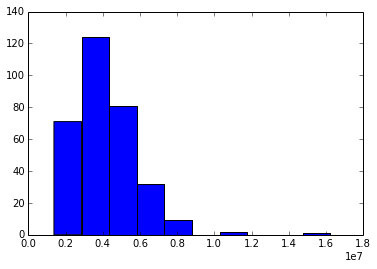

In [50]:
plt.hist(counts_newsetup.sum(axis=1))
print list(counts_newsetup.sum(axis=1))